In [74]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import folium


def get_df(file_name):
    df = pd.read_csv(file_name)
    df = df.set_index('SectionId')
    return(df)


def totalvol_regression(df, degree):
    X = df['time'].str.slice(0, 2).astype(int) + df['time'].str.slice(3, 5).astype(int)/60
    y = df['TotalVol'].values

    X = X.values.reshape(-1, 1)
    y = y.reshape(-1, 1)

    PF = PolynomialFeatures(degree)
    LR = LinearRegression()
    LR.fit(PF.fit_transform(X), y)
    X_predict = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_predict = LR.predict(PF.transform(X_predict))

    return X, y, X_predict, y_predict
    
    
def draw_plot(section_id, df3, df6, degree):
    location = [
        list((df3.loc[section_id, 'StartWgsY'] + df3.loc[section_id, 'EndWgsY'])/2)[0],
        list((df3.loc[section_id, 'StartWgsX'] + df3.loc[section_id, 'EndWgsX'])/2)[0]
    ]

    output = {
        'location': location,
        'section_id': section_id,
        'weekday': {},
        'weekend': {}
    }
    plt.figure(figsize=(20,10))
    plt.title(section_id)
    plt.xlabel('Hours')
    plt.ylabel('Volume')
    plt.xlim(8, 22)
    plt.ylim(0, 160)
    plt.grid(True)

    df = df3.loc[section_id]
    X, y, X_predict, y_predict = totalvol_regression(df, degree)
    output['weekday'] = {
        'x': X.tolist(), 
        'y': y.tolist(), 
        'x_predict': X_predict.tolist(), 
        'y_predict': y_predict.tolist()
    }

    plt.scatter(X, y, color = '#2980B9', s=8)
    plt.plot(X_predict, y_predict, '#2980B9', linewidth=10)

    df = df6.loc[section_id]
    X, y, X_predict, y_predict = totalvol_regression(df, degree)
    output['weekend'] = {
        'x': X.tolist(), 
        'y': y.tolist(), 
        'x_predict': X_predict.tolist(), 
        'y_predict': y_predict.tolist()
    }

    plt.scatter(X, y, color = '#E67E22', s=8)
    plt.plot(X_predict, y_predict, '#E67E22', linewidth=10)

    plt.show()

    return output

In [75]:
## file path
file_weekday = 'traffic_csv/GetVD_06-03.csv'
file_weekend = 'traffic_csv/GetVD_06-06.csv'
file_name = 'Traffic_csv/GetVD_06-03_1800.csv' #0800, 1300, 1800, 2200
list_id = ['ZKWNV20', 'ZPLKP40', 'ZP8FZ00', 'ZN5JX60', 'ZP6JY60', 
           'ZKLPX00', 'ZFTLH60' ,'ZJCTT60', 'ZJTJ820', 'ZKXET20']

df3 = get_df(file_weekday)
df6 = get_df(file_weekend)

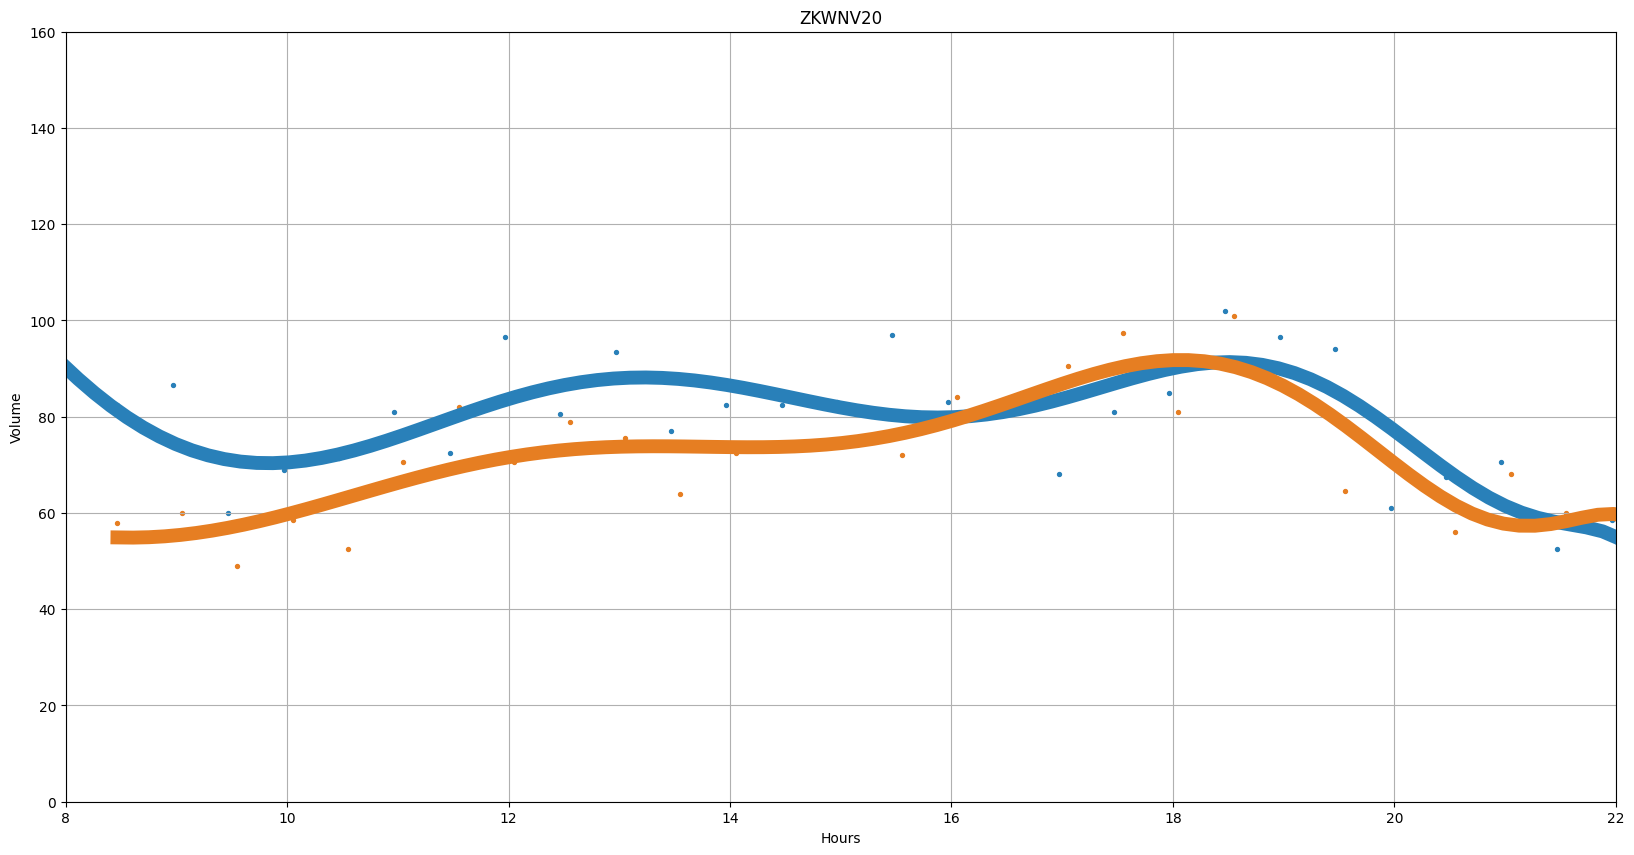

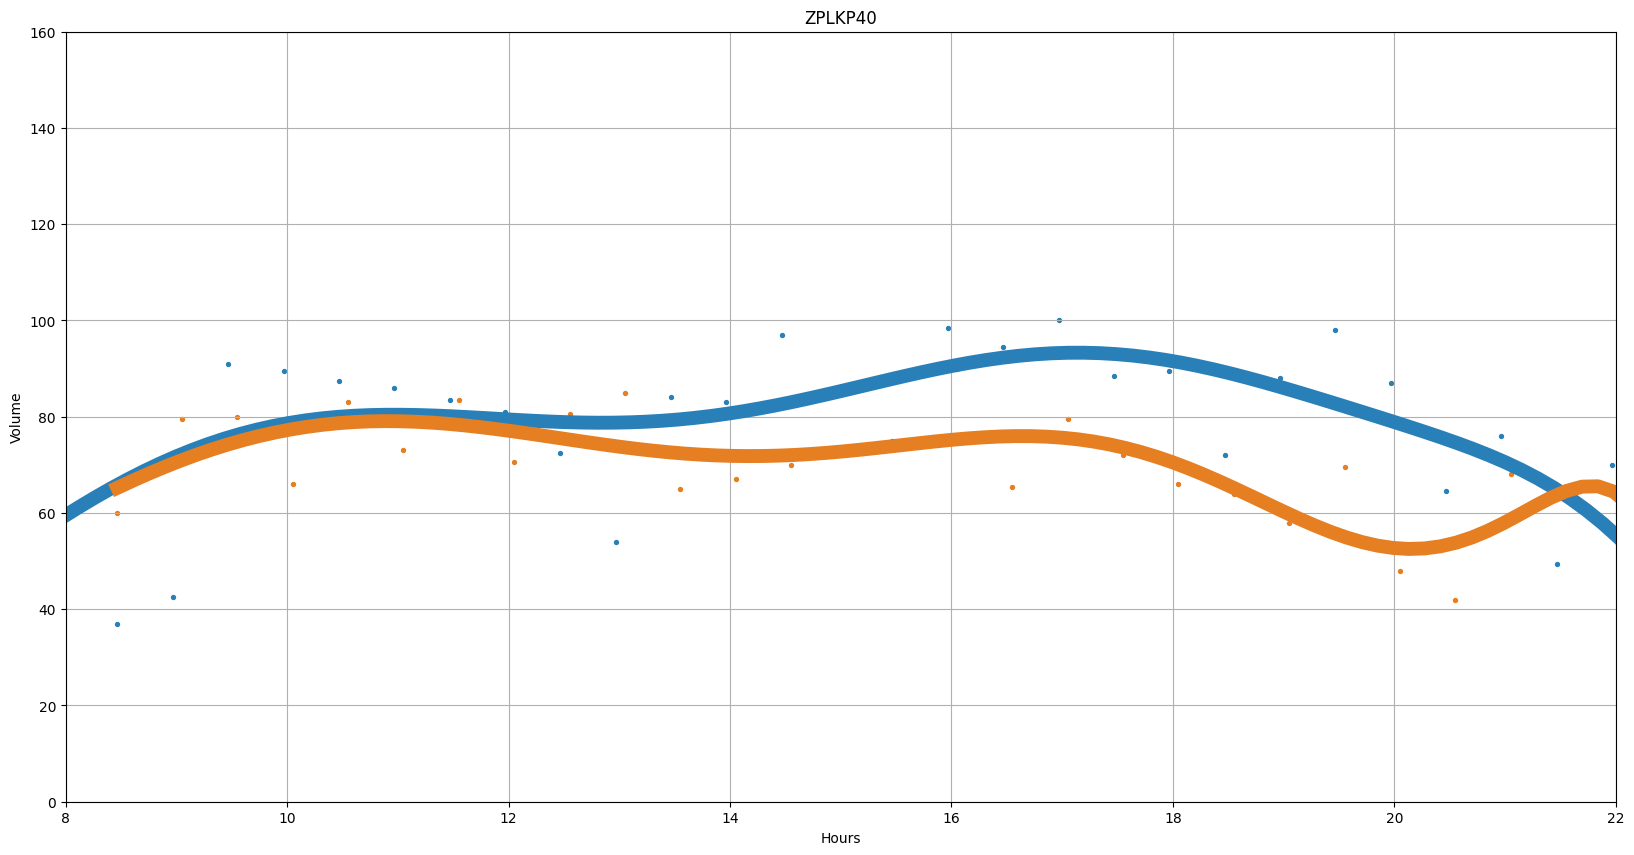

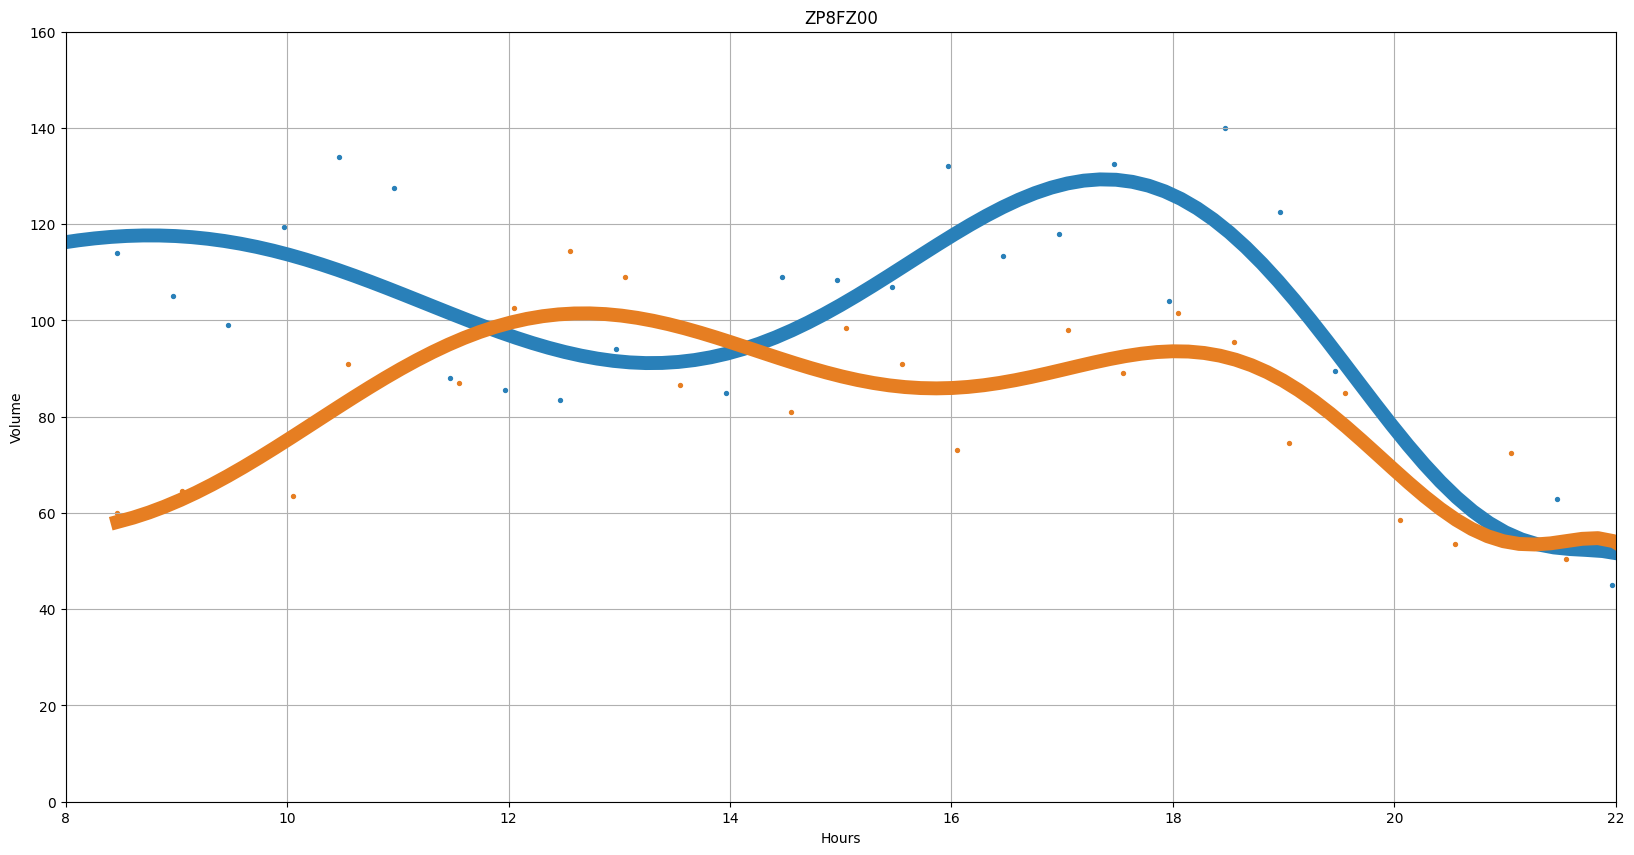

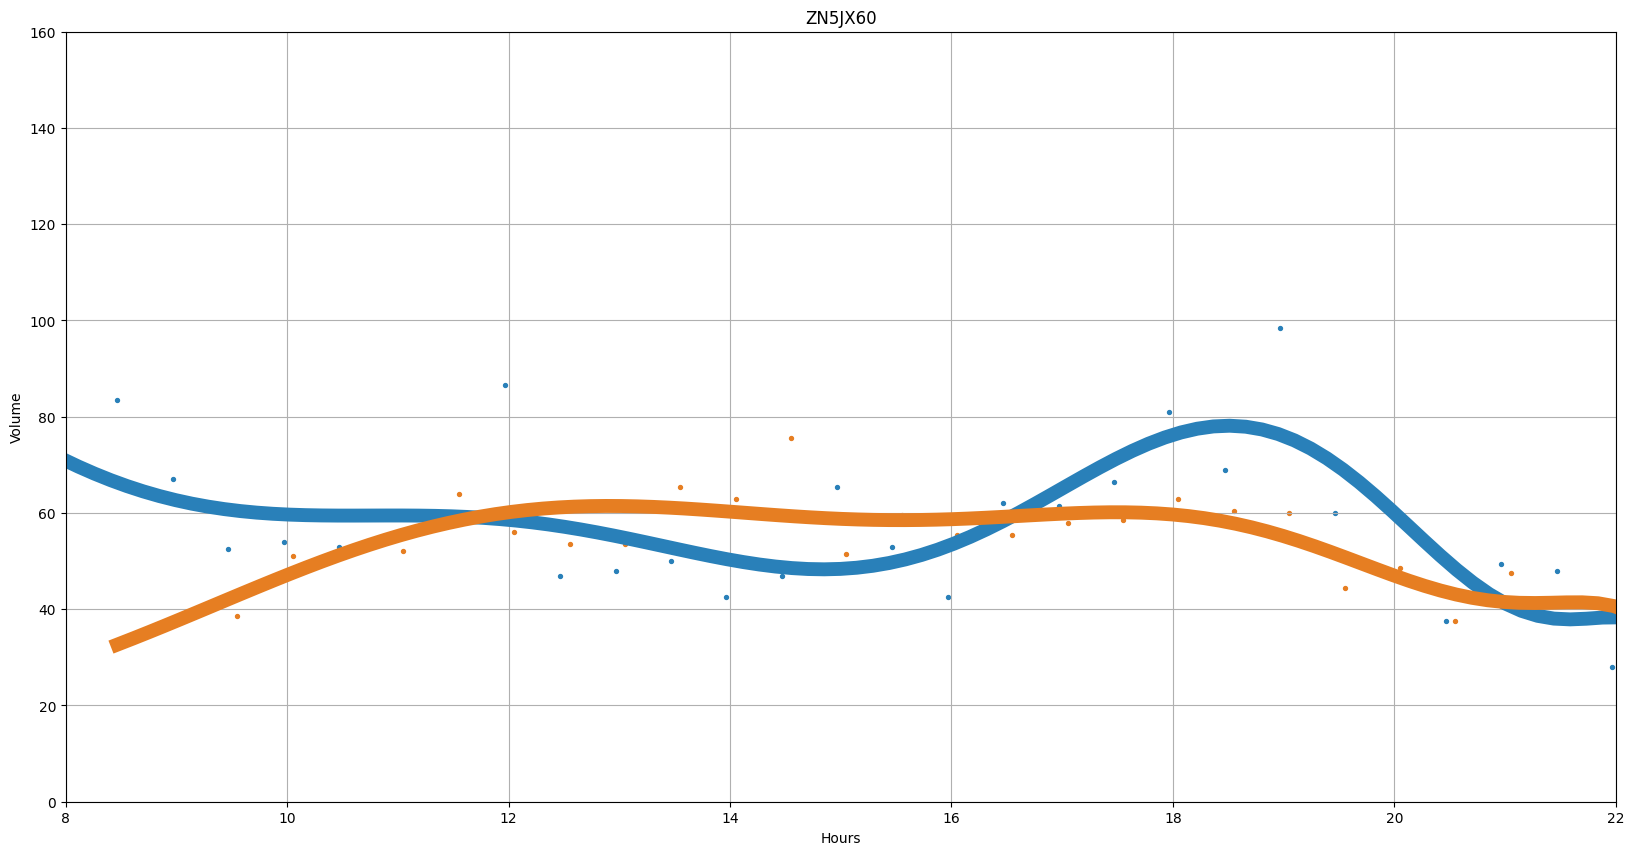

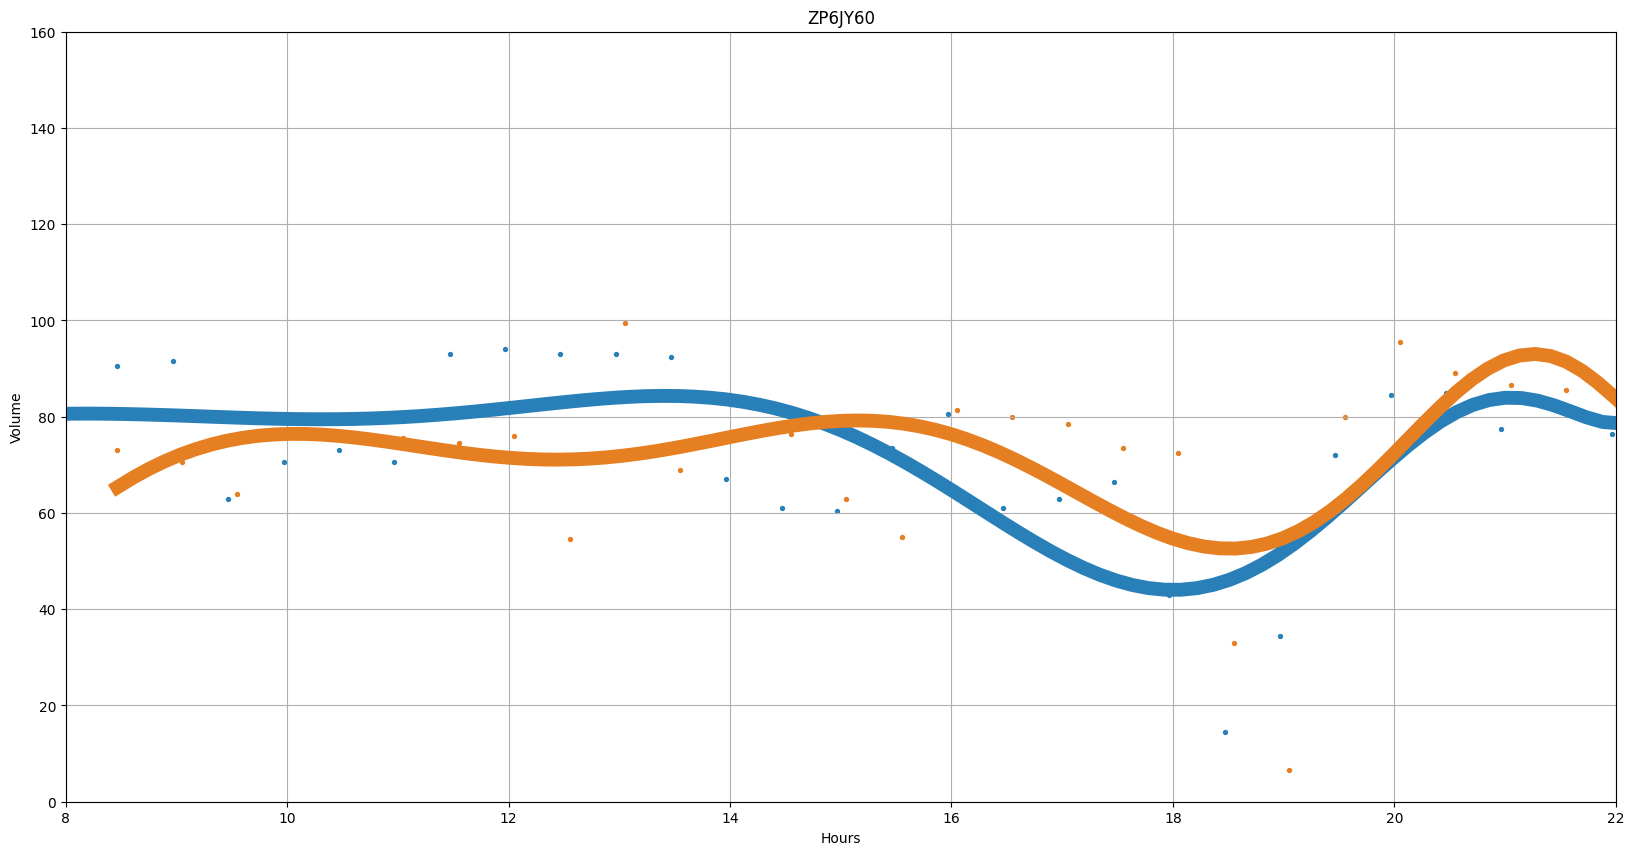

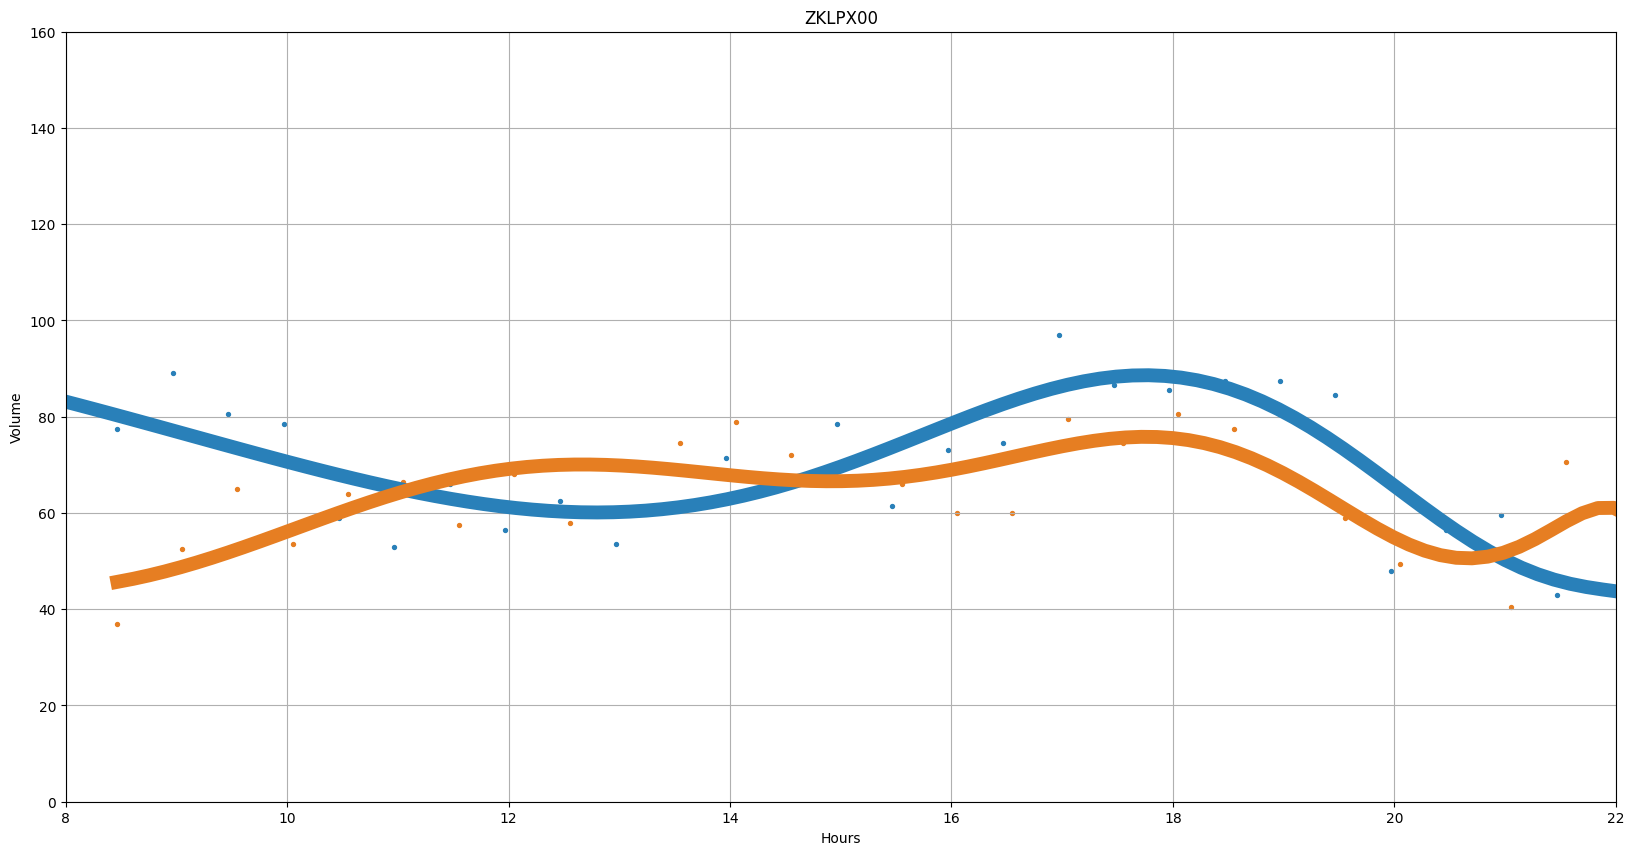

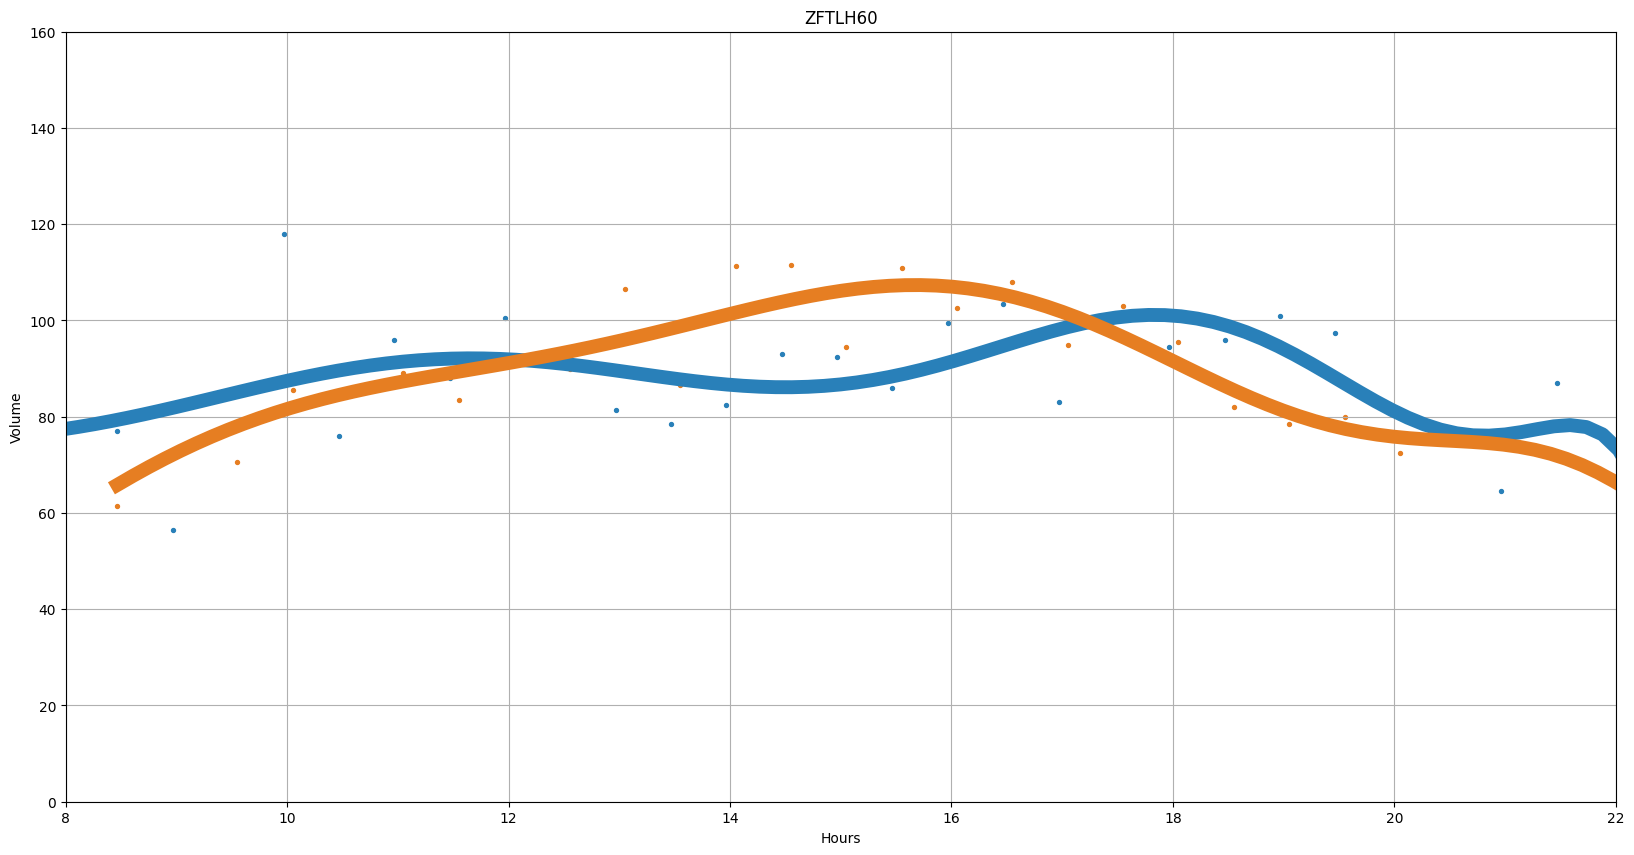

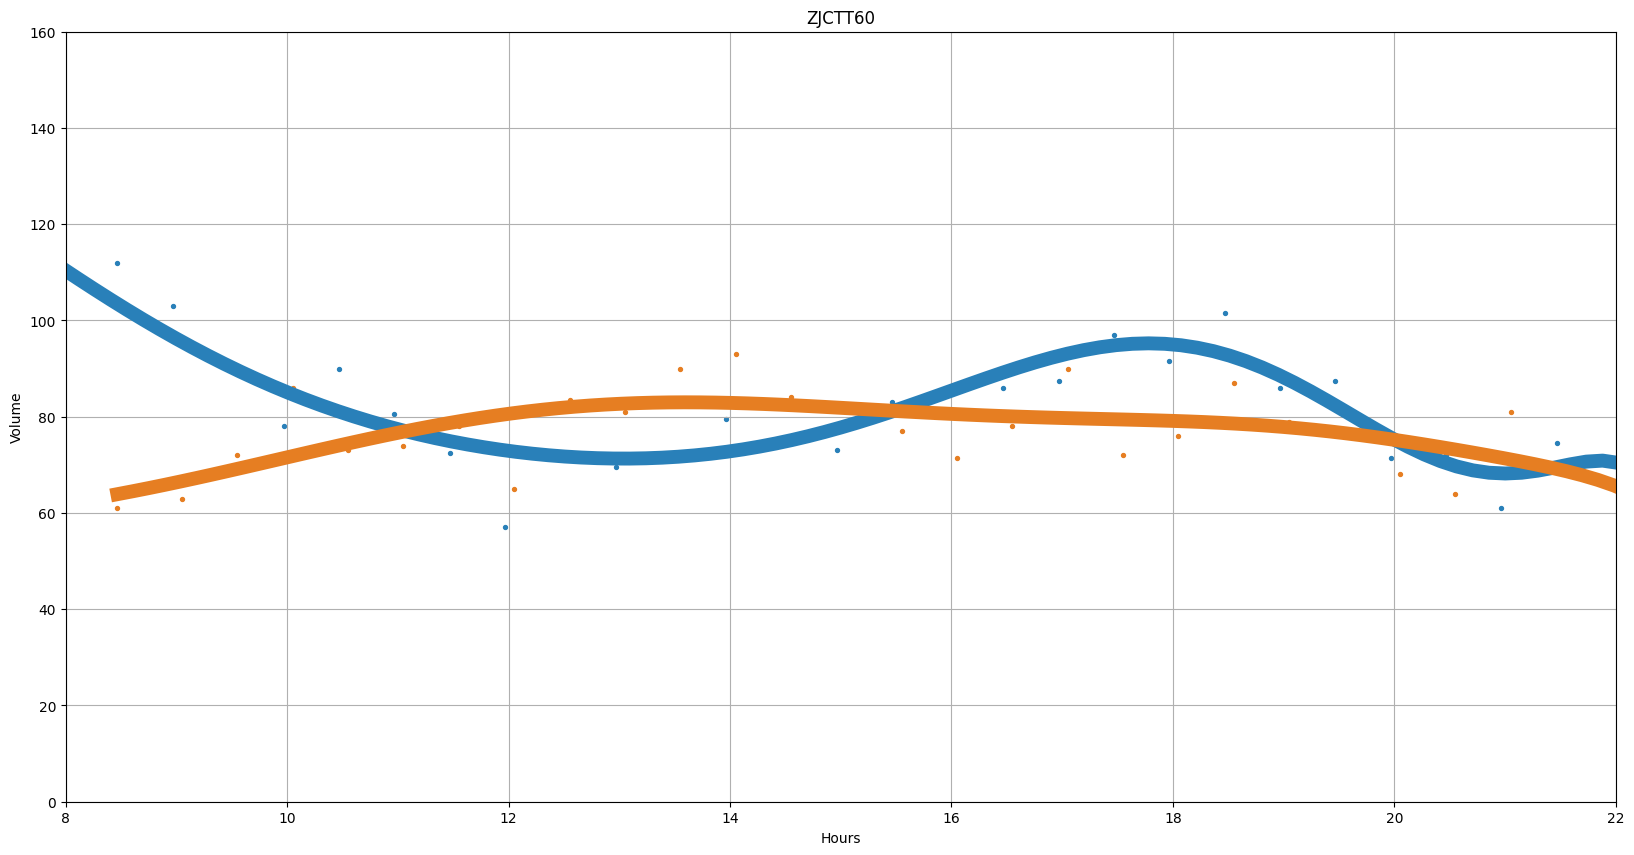

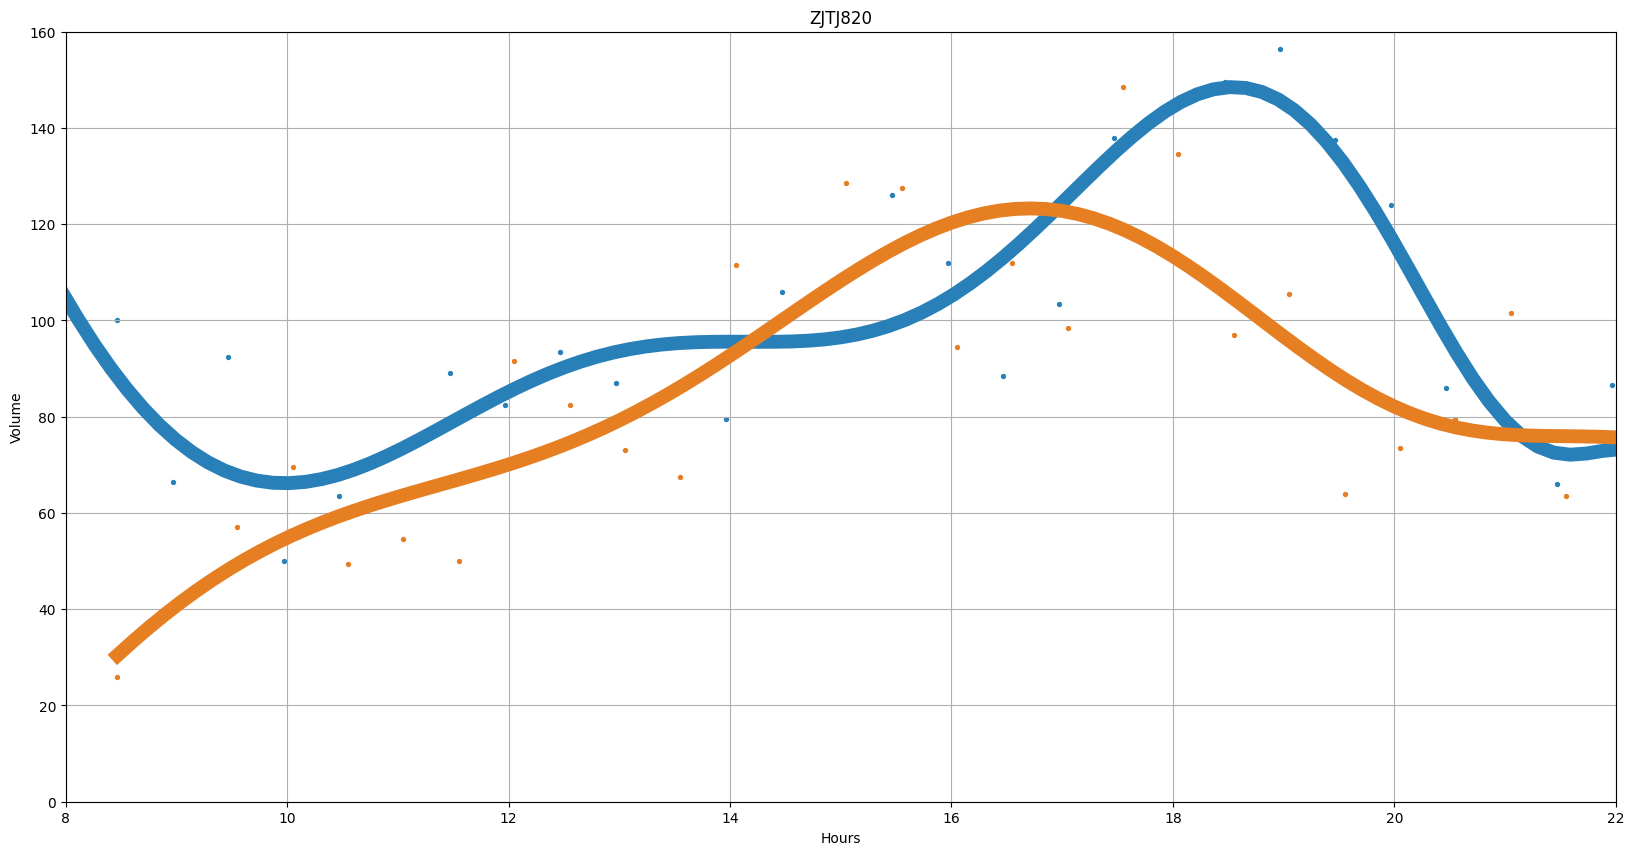

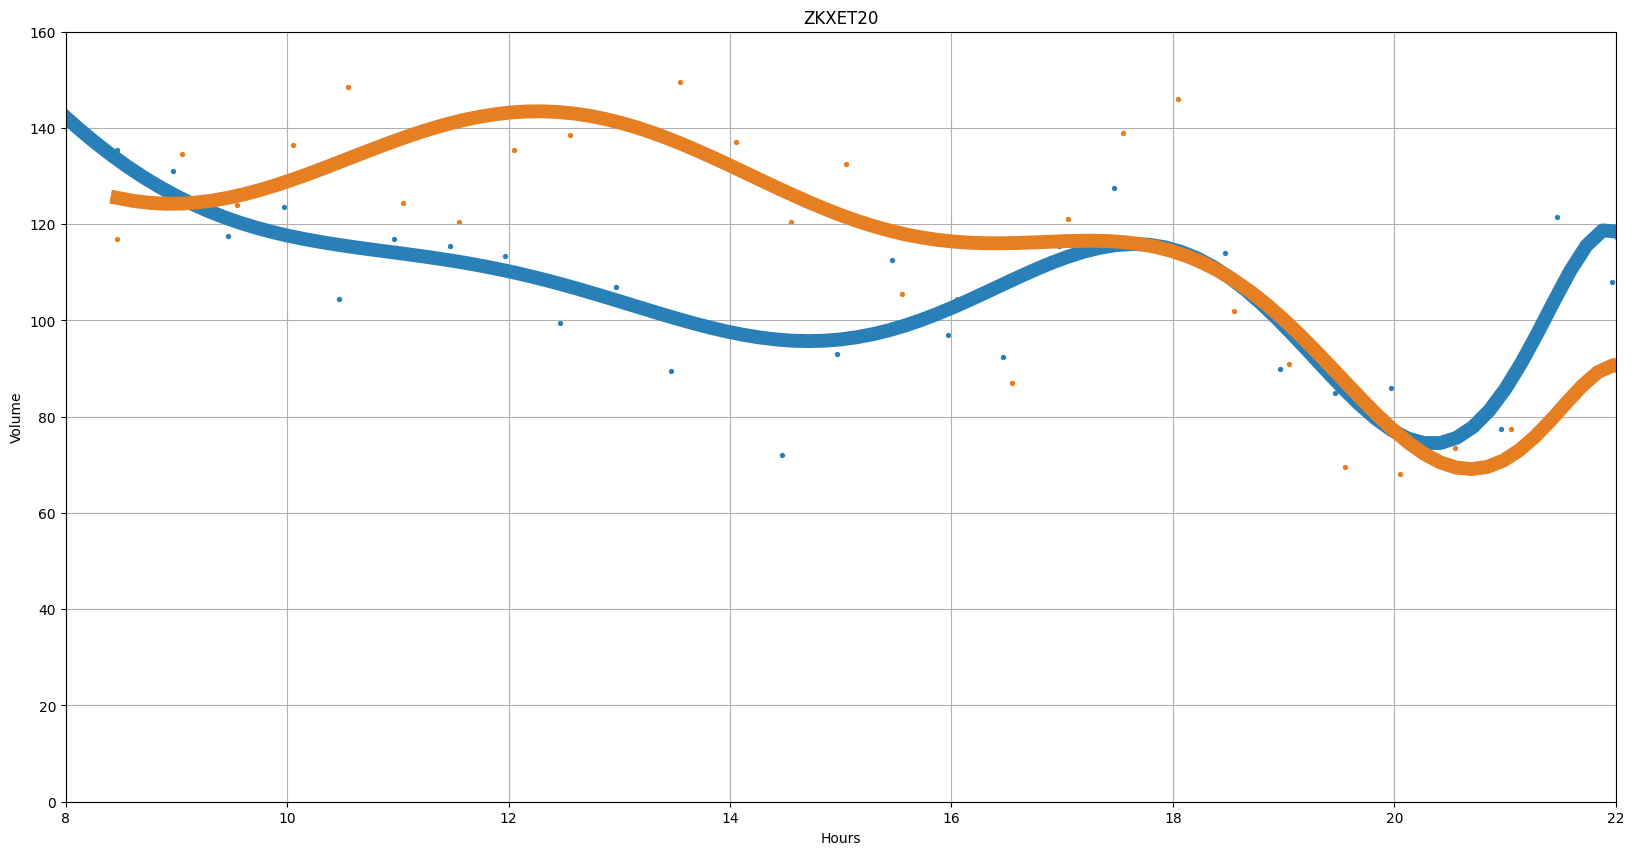

In [76]:
outputs = []
for i in list_id:
    output = draw_plot(i, df3, df6, 12)
    outputs.append(output)

with open("../public/data/traffic.json", "w") as f:
    json.dump(outputs, f)

In [66]:
'''
"OpenStreetMap"
"Stamen Terrain", "Stamen Toner", "Stamen Watercolor"
"CartoDB positron", "CartoDB dark_matter"
"Mapbox Bright", "Mapbox Control Room" (Limited zoom)
"Cloudmade" (Must pass API key)
"Mapbox" (Must pass API key)
'''

m = folium.Map((25.048, 121.55), tiles="CartoDB positron", zoom_start=13)

for i in list_id:
    x = list((df3.loc[i, 'StartWgsX'] + df3.loc[i, 'EndWgsX'])/2)[0]
    y = list((df3.loc[i, 'StartWgsY'] + df3.loc[i, 'EndWgsY'])/2)[0]
    i = [y, x]
    n = folium.CircleMarker(
        location = i,
        radius = 1,
        color = '#1F618D',
        fill = True,
        fill_opacity = 1,
        fill_color = '#1F618D'
    ).add_to(m)

m